import everything

In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter
import imageio



if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    %run ../BehavioralPaper/TaskRules.ipynb
    os.chdir(CWD)
    # PARAMETERS (used if the pickles don't exist)
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }  

    if OS()=='Linux':
        root="/data"
    elif OS()=='Windows':
        root="C:\\DATA\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"
        
    logging.getLogger().setLevel(logging.ERROR)

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

# part 1:

# DEFINITIONS

### If you don't know, move to part 2

Drawing the reward magnitude

In [ ]:
def plot_reward_progression_schematic(ax, minReward, gt, maxTrial, maxReward, step, color,showYAxis):
    points=[(i,(i-minReward)/(gt-minReward)*.6) for i in np.arange(minReward,gt,step)]
    rewardRatio = lambda x: (-x/(maxReward-gt)+ (maxReward/(maxReward-gt)))

    for x,alpha in points:
        ax.plot( (x,gt), (0,1), alpha=alpha, color=color )

    ax.plot( (gt,gt), (1,0), alpha=1, color=color, lw=2 )
    ax.plot( (gt,maxTrial), (1,rewardRatio(maxTrial)), alpha=1, color=color, lw=2 )
    ax.plot( (maxTrial,maxReward), (rewardRatio(maxTrial),0), ':', alpha=1, color=color, lw=2)

    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([minReward, gt, maxTrial, maxReward])
    ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_xlim([minReward,maxReward])
    if showYAxis:
        ax.yaxis.set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.set_ylim([0,1])
        ax.set_yticks([0,1])
        ax.set_yticklabels(['zero', 'max'])

    #adding the text
    ax.set_title('Reward\nMagnitude')
    ax.set_xlabel('Entrance Time (s)')
    
    return ax

In [ ]:
if "__file__" not in dir():
    minReward=1.5
    gt=7
    maxTrial=15
    maxReward=20
    step=.8
    color='r'
    showYAxis=False
    ax=plt.figure(figsize=(2,2)).add_subplot(111);

    plot_reward_progression_schematic(ax, minReward, gt, maxTrial, maxReward, step, color,showYAxis)
    
    plt.show()
    plt.close('all')

Drawing task rules 

In [ ]:
def plot_task_rules(fig, gs, hspace, alpha, xmin, xmax, et, GT, maxP, fontsize):
    gssub = gs.subgridspec(4, 1,hspace=hspace)
    goodAx=fig.add_subplot(gssub[1, 0])
    earlyAx =fig.add_subplot(gssub[2, 0])
    omitAx =fig.add_subplot(gssub[3, 0])
    treadmillAx =fig.add_subplot(gssub[0, 0])
    axes=(goodAx,earlyAx, omitAx)
    ET,ET0,ET1=et
    
    #good trials
    ######################################
    
    r=np.array([0,1])

    #light on
    goodAx.fill_betweenx(y=r,x1=-1,x2=ET, facecolor='yellow', edgecolor='', alpha=alpha)
    goodAx.fill_betweenx(y=r,x1=-10,x2=-1, facecolor='gray', edgecolor='', alpha=alpha)
    goodAx.fill_betweenx(y=r,x1=ET,x2=30, facecolor='gray', edgecolor='', alpha=alpha)
    goodAx.text(x=-1, y=r.mean(), s='Light ON', verticalalignment='center', fontsize=fontsize)
    goodAx.text(x=ET, y=r.mean(), s='Intertrial\nReward', verticalalignment='center', fontsize=fontsize-1)

#     r+=1
#     #motor running
#     goodAx.fill_betweenx(y=r,x1=0,x2=ET, facecolor='cyan', edgecolor='', alpha=alpha)
#     goodAx.text(x=0, y=r.mean(), s='Motor ON', verticalalignment='center', fontsize=fontsize)

    r+=1
    #beam ignore
    goodAx.fill_betweenx(y=r,x1=0,x2=1.5, facecolor='pink', edgecolor='', alpha=alpha)
    goodAx.text(x=0, y=r.mean(), s='Beam OFF', verticalalignment='center', fontsize=fontsize)

#     # r+=1
#     #entrance times
#     goodAx.fill_betweenx(y=r,x1=GT,x2=15, facecolor='lime', edgecolor='', alpha=alpha)
#     goodAx.text(x=GT, y=r.mean(), s='Entrance time range', verticalalignment='center', fontsize=fontsize)

    #Correct trials
    goodAx.text(x=xmin, y=4, s='Correct trial '+'$(7\leq ET<15 s)$', verticalalignment='center', fontsize=fontsize)



    #early trials
    ######################################
    r=np.array([0,1])

    #light on
    earlyAx.fill_betweenx(y=r,x1=-1,x2=maxP, facecolor='yellow', edgecolor='', alpha=alpha)
    earlyAx.fill_betweenx(y=r,x1=-10,x2=-1, facecolor='gray', edgecolor='', alpha=alpha)
    earlyAx.fill_betweenx(y=r,x1=maxP,x2=30, facecolor='gray', edgecolor='', alpha=alpha)
    # earlyAx.text(x=-1, y=r.mean(), s='Light ON', verticalalignment='center', fontsize=fontsize)
    earlyAx.text(x=maxP, y=r.mean(), s='Intertrial\nNo reward', verticalalignment='center', fontsize=fontsize-1)

#     r+=1
#     #motor running
#     earlyAx.fill_betweenx(y=r,x1=0,x2=maxP, facecolor='cyan', edgecolor='', alpha=alpha)
#     # earlyAx.text(x=0, y=r.mean(), s='Motor ON', verticalalignment='center', fontsize=fontsize)

    r+=1
    #beam ignore
    earlyAx.fill_betweenx(y=r,x1=0,x2=1.5, facecolor='pink', edgecolor='', alpha=alpha)
    # earlyAx.text(x=0, y=r.mean(), s='Beam OFF', verticalalignment='center', fontsize=fontsize)

    # r+=1
    # punishment
    earlyAx.fill_betweenx(y=r,x1=ET0,x2=maxP, facecolor='r', edgecolor='', alpha=alpha)
    earlyAx.text(x=ET0, y=r.mean(), s='Punishment', verticalalignment='center', fontsize=fontsize,zorder=5)

#     r+=1
#     #entrance times
#     earlyAx.fill_betweenx(y=r,x1=1.5,x2=GT, facecolor='lime', edgecolor='', alpha=alpha)
#     # earlyAx.text(x=1.5, y=r.mean(), s='Entrance time range', verticalalignment='center', fontsize=fontsize)

    #INCorrect trials
    earlyAx.text(x=xmin, y=4, s='Incorrect trial '+'$(1.5\leq ET<7 s)$', verticalalignment='center', fontsize=fontsize)
    
    
    #omit trials
    ######################################
    r=np.array([0,1])

    #light on
    omitAx.fill_betweenx(y=r,x1=-1,x2=15, facecolor='yellow', edgecolor='', alpha=alpha)
    omitAx.fill_betweenx(y=r,x1=-10,x2=-1, facecolor='gray', edgecolor='', alpha=alpha)
    omitAx.fill_betweenx(y=r,x1=15,x2=30, facecolor='gray', edgecolor='', alpha=alpha)
    # omitAx.text(x=-1, y=r.mean(), s='Light ON', verticalalignment='center', fontsize=fontsize)
#     omitAx.text(x=15, y=r.mean(), s='Intertrial, no reward', verticalalignment='center', fontsize=fontsize)

#     r+=1
#     #motor running
#     omitAx.fill_betweenx(y=r,x1=0,x2=maxP, facecolor='cyan', edgecolor='', alpha=alpha)
#     # omitAx.text(x=0, y=r.mean(), s='Motor ON', verticalalignment='center', fontsize=fontsize)

    r+=1
    #beam ignore
    omitAx.fill_betweenx(y=r,x1=0,x2=1.5, facecolor='pink', edgecolor='', alpha=alpha)
    # omitAx.text(x=0, y=r.mean(), s='Beam OFF', verticalalignment='center', fontsize=fontsize)

    # r+=1
#     # punishment
#     omitAx.fill_betweenx(y=r,x1=ET0,x2=maxP, facecolor='r', edgecolor='', alpha=alpha)
#     omitAx.text(x=ET0, y=r.mean(), s='Punishment', verticalalignment='center', fontsize=fontsize,zorder=5)

#     r+=1
#     #entrance times
#     omitAx.fill_betweenx(y=r,x1=1.5,x2=GT, facecolor='lime', edgecolor='', alpha=alpha)
#     # omitAx.text(x=1.5, y=r.mean(), s='Entrance time range', verticalalignment='center', fontsize=fontsize)

    omitAx.text(x=xmin, y=4, s='Omitted trial '+'$(No\  ET)$', verticalalignment='center', fontsize=fontsize)


    #common axes
    for i,ax in enumerate(axes):
        ax.vlines(x=GT, ymin=0, ymax=3, color='m', linestyles='--', zorder=2)
        ax.vlines(x=et[i], ymin=-5, ymax=bool(i), color='k', linestyles='-', zorder=2, lw=.8)
        ax.set_xlim([xmin,xmax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xticks([-1,0,1.5,7,15])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.set_ylim([-.1,5])

    goodAx.text(x=GT, y=2.5, s='Goal time', ha='center', fontsize=fontsize, color='m', backgroundcolor='w')

    goodAx.set_xticklabels([])

    #adding ET
    goodAx.set_xticks(list(goodAx.get_xticks())+[ET])
    l=[]
    for tick in goodAx.get_xticks():
        if tick==ET:
            l.append('$ET$')
        else:
            l.append('')
    goodAx.set_xticklabels(l)

    earlyAx.set_xticks(list(earlyAx.get_xticks())+[ET0])
    l=[]
    for tick in earlyAx.get_xticks():
        if tick==ET0:
            l.append('$ET$')
        else:
            l.append('')
    earlyAx.set_xticklabels(l)
    

    # omitAx.set_xlabel(r'$\longrightarrow$'+'\n'+'Time(s)')
    omitAx.set_xlabel('Time (s)')

    


    # fig.add_artist(matplotlib.patches.FancyArrow(.45, 0, dx=.12, dy=0,length_includes_head=True,
    #                                              head_width=.02, head_length=.01, color='k'))
    
    axes=treadmillAx,*axes
    return axes

In [ ]:
if "__file__" not in dir():

    alpha=1
    hspace=.4
    xmin,xmax=(-2,16)
    et=(9,5,15)
    GT=7
    maxP=10 #punishment
    fontsize=6

    plt.close('all')
    fig=plt.figure(figsize=(5,3),dpi=200)
    gs=fig.add_gridspec(1,1)[0]
    axes=plot_task_rules(fig, gs, hspace, alpha, xmin, xmax, et, GT, maxP,fontsize)
    axes[0].xaxis.set_visible(False)
    axes[0].yaxis.set_visible(False)
    
    plt.show()

# part 2:

# GENERATING THE FIGURE

Parameters

In [ ]:
if "__file__" not in dir():
    # GRID 1 PARAMS
    alpha=1
    hspace=.3
    xmin,xmax=(-2,16)
    et=(9,4,15)
    GT=7
    maxP=10 #punishment
    fontsize=8
    

Plotting

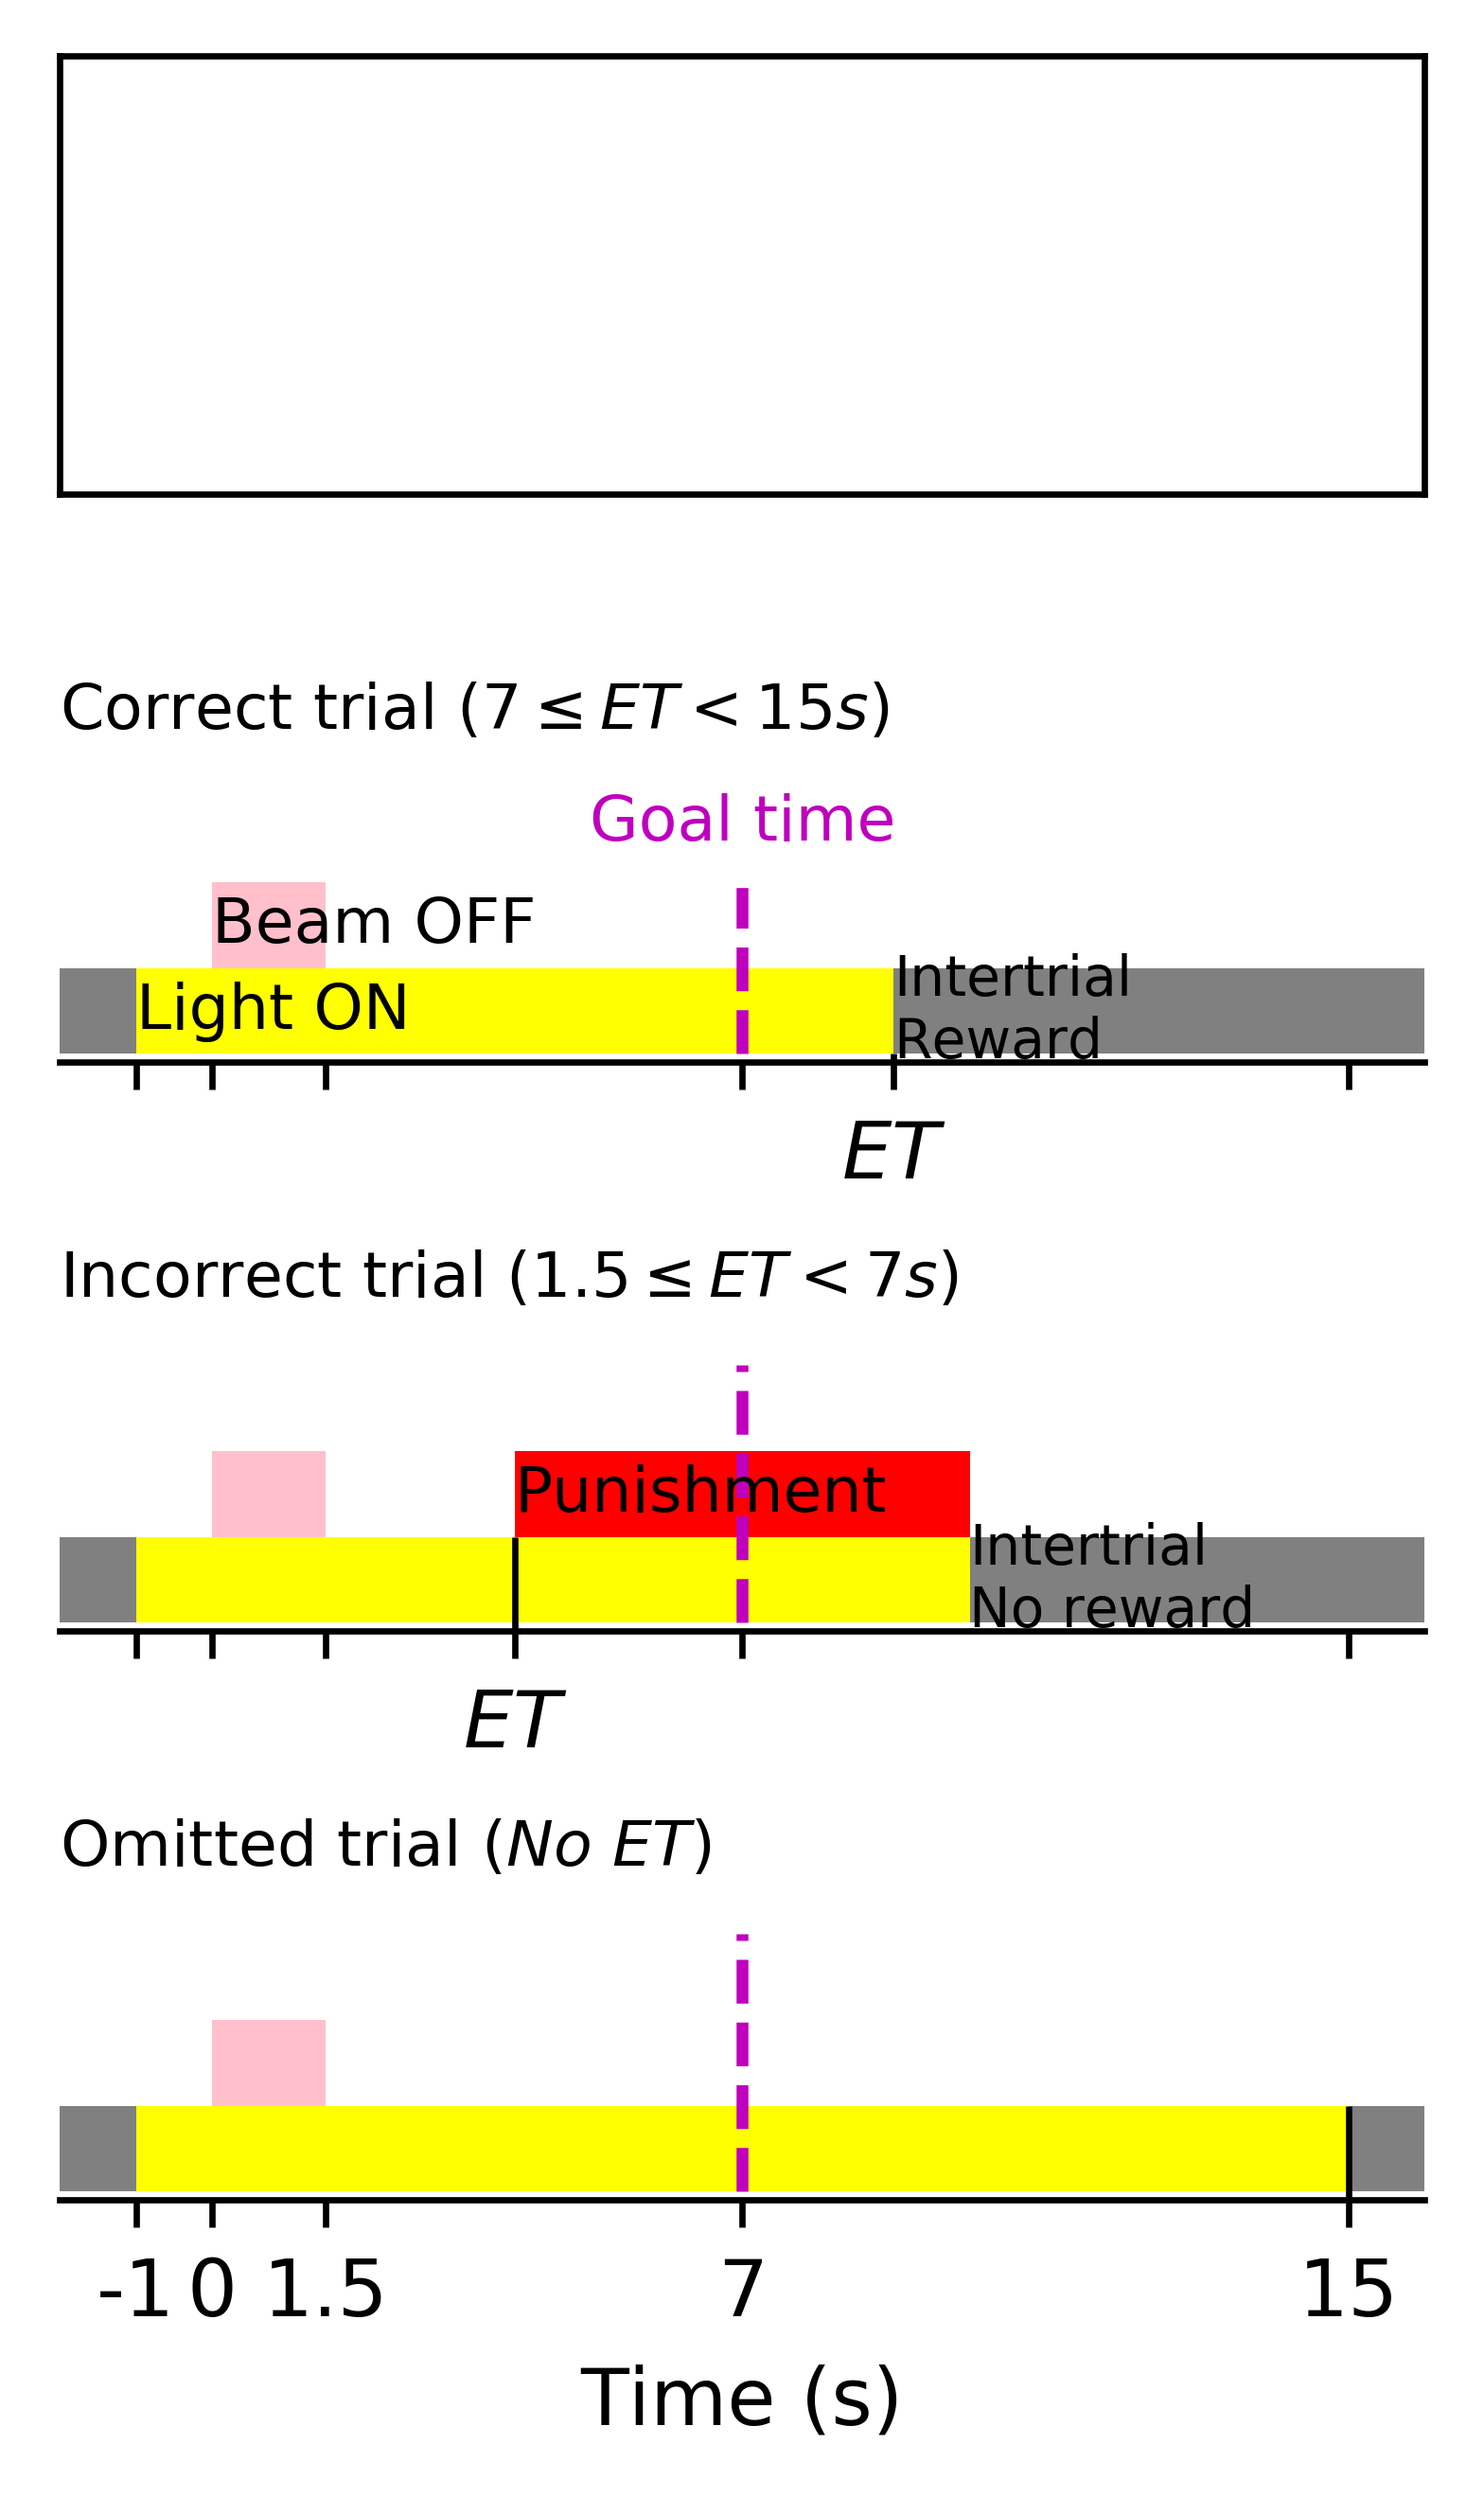

In [14]:
if "__file__" not in dir():
    plt.close('all')
    figsize=(3.1,5)
    fig=plt.figure(figsize=figsize,dpi=600)
    
    
    ##########################################
    # 1: task rules
    gs1=fig.add_gridspec(1,1)[0]
    axes=plot_task_rules(fig, gs1, hspace, alpha, xmin, xmax, et, GT, maxP,fontsize)
    axes[0].xaxis.set_visible(False)
    axes[0].yaxis.set_visible(False)
    

        
    

#     fig.savefig('/home/david/Pictures/TaskRules.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')